# Easy21 Task #4

Max Schrader

In [2]:
import numpy as np
from copy import copy, deepcopy
from random import random, choice, randint, uniform
import plotly.graph_objects as go

## Creating the Objects

### Cards

In [3]:
ACTIONS = {1: 'STICK', 0: 'HIT'}


class Cards:
    def __init__(self):
        self.distribution_range = (1, 10)

    def get_card(self, first=False):
        return randint(*self.distribution_range) * 1 if (uniform(0, 1) < 2 / 3) or first \
            else -1 * randint(*self.distribution_range)

### The Player

In [4]:
class Player:
    def __init__(self):
        self._cards = []
        self._sum = 0

    def check_bust(self):
        if self._sum < 1 or self._sum > 21:
            return True
        return False

    def clear_cards(self):
        self._cards = []
        self._sum = 0

    def add_card(self, card):
        self._cards.append(card)
        self._sum = sum(self._cards)

    def get_sum(self):
        return self._sum

    def get_card(self, index):
        return self._cards[index]

### The Dealer

In [5]:
class Dealer(Player):
    STICK_THRESHOLD = 17

    def __init__(self):
        super(Dealer, self).__init__()

    def play_strategy(self, card):
        self.add_card(card)
        if not self.check_bust():
            if self.get_sum() < self.STICK_THRESHOLD:
                return True
        return False

### The Observed State

In [6]:
class State:
    def __init__(self, player_sum, dealer_first):
        self.dealer_first = dealer_first
        self.player_sum = player_sum
        self.terminal = False

    def copy(self):
        return copy(self)

### The Game

In [7]:
class Easy21:

    def __init__(self, ):
        self.dealer = Dealer()
        self.player = Player()
        self.cards = Cards()
        self.states = [range(1, 11), range(1, 22)]
        self.actions = ACTIONS
        self.actions_short = list(range(len(self.actions.keys())))

    def reset(self):
        self.__init__()

    def initialize_game(self):
        self.dealer.clear_cards()
        self.player.clear_cards()
        self.dealer.add_card(self.cards.get_card(first=True))
        self.player.add_card(self.cards.get_card(first=True))
        s = State(self.player.get_sum(), self.dealer.get_card(0))
        return s

    def calc_reward(self):
        if self.dealer.check_bust() or (self.player.get_sum() > self.dealer.get_sum()):
            return 1
        elif self.player.get_sum() == self.dealer.get_sum():
            return 0
        return -1

    def step(self, action, state):
        state_1 = state.copy()
        if action == 1:
            while self.dealer.play_strategy(self.cards.get_card()):
                pass
            r = self.calc_reward()
            state_1.terminal = True
        else:
            card = self.cards.get_card()
            self.player.add_card(card)
            if self.player.check_bust():
                state_1.terminal = True
                r = -1
            else:
                state_1.player_sum = self.player.get_sum()
                r = 0
        return state_1, r

## Monte-Carlo Class (Serves as the Base Class for the Linear Function Class)

In [8]:
class MonteCarloAgent:

    def __init__(self, gym: Easy21):
        self.gym = gym()
        self.Q = np.zeros((len(self.gym.states[1]), len(self.gym.states[0]), len(self.gym.actions_short)))
        self.N = deepcopy(self.Q)
        self.N0 = 100
        self.discount_factor = 1

    def calc_e(self, state: State) -> float:
        return self.N0 / (self.N0 + self.N[state.player_sum - 1, state.dealer_first - 1].sum() * 1.)

    def get_best_action(self, state):
        rewards = self.Q[state.player_sum - 1][state.dealer_first - 1]
        max_reward = max(rewards)
        return choice([self.gym.actions_short[i] for i, reward in enumerate(rewards) if reward >= max_reward])

    def e_greedy(self, state):
        e = self.calc_e(state)
        if random() < e:
            return choice(self.gym.actions_short)
        else:
            return self.get_best_action(state)

    def update_q(self, history):
        for i, (s_k, a_k, r_k) in enumerate(history):
            p_i = s_k.player_sum - 1
            d_i = s_k.dealer_first - 1
            G_t = sum([r_j * (self.discount_factor ** j) for j, (_, _, r_j) in enumerate(history[i:])])
            self.N[p_i, d_i, a_k] += 1
            alpha = 1.0 / self.N[p_i, d_i, a_k]
            self.Q[p_i, d_i, a_k] += alpha * (G_t - self.Q[p_i, d_i, a_k])

    def _train(self, ):
        self.gym.reset()
        s_t = self.gym.initialize_game()
        history = []
        while not s_t.terminal:
            a_t = self.e_greedy(s_t)
            s_t_1, r_t = self.gym.step(a_t, s_t)
            history.append([s_t, a_t, r_t])
            s_t = s_t_1
        self.update_q(history)

    def run(self, iterations, ):
        for _ in range(int(iterations)):
            self._train()

    def get_V_star(self, ):
        player_sum = list(self.gym.states[1])
        dealer_showing = list(self.gym.states[0])
        V_star = [[max(actions) for actions in dealer] for dealer in self.Q]
        return player_sum, dealer_showing, V_star

In [9]:
mc_agent = MonteCarloAgent(gym=Easy21, )

In [10]:
mc_agent.run(iterations=int(5e5))

## Linear Function Approximation

In [129]:
class LinearFunctionApproximation(MonteCarloAgent):

    def __init__(self, gym, Q_star=None):
        super(LinearFunctionApproximation, self).__init__(gym)

        self._e = 0.05
        self._lambda = 1
        self._alpha = 0.01
        self.Q_star = Q_star
        self._dealer_c = [[1, 4], [4, 7], [7, 10]]
        self._player_c = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
        self._action_c = [0, 1]
        # parameters are initialize randomly
        self._shape = list(map(len, [self._dealer_c, self._player_c, self._action_c]))
        self._theta = self.calc_theta()
        self._shaped_zeros = np.zeros(self._shape)
        self._E = copy(self._shaped_zeros)
        self._param_num = np.prod(self._shape)

    def calc_theta(self):
        return np.random.randn(*self._shape) * 0.1

    def phi(self, s, a):
        d_sum, p_sum = s.dealer_first, s.player_sum
        features = copy(self._shaped_zeros)
        d_features = [(i, x[0] <= d_sum <= x[1]) for i, x in enumerate(self._dealer_c)]
        p_features = [(i, x[0] <= p_sum <= x[1]) for i, x in enumerate(self._player_c)]
        for i, d_inside in d_features:
            if d_inside:
                for j, p_inside in p_features:
                    if p_inside:
                        features[i, j, a] = 1
        return features

    def get_best_action(self, state):
        rewards = [np.dot(self.phi(state, a).flatten(), self._theta.flatten()) for a in self._action_c]
        max_reward = max(rewards)
        return choice([self.gym.actions_short[i] for i, reward in enumerate(rewards) if reward >= max_reward])

    def calc_e(self, state=None) -> float:
        return self._e

    def compose_Q(self):
        Q = np.zeros((len(self.gym.states[0]), len(self.gym.states[1]), len(self.gym.actions_short)))
        for i in self.gym.states[0]:
            for j in self.gym.states[1]:
                for a in self.gym.actions_short:
                    Q[i - 1, j - 1, a] = np.dot(self.phi(State(player_sum=j, dealer_first=i), a).flatten(), self._theta.flatten())
        return Q

    def _step(self, log_error):
        self.gym.reset()
        s_t = self.gym.initialize_game()
        a_t = self.e_greedy(s_t)
        self._E = copy(self._shaped_zeros)
#         self._theta = self.calc_theta()
        a_t_1 = a_t
        while not s_t.terminal:
            s_t_1, r_t = self.gym.step(a_t, s_t)
            phi_t = self.phi(s_t, a_t)
            q = np.dot(phi_t.flatten(), self._theta.flatten())
            if not s_t_1.terminal:
                a_t_1 = self.e_greedy(s_t_1)
                phi_t_1 = self.phi(s_t_1, a_t_1)
                q_t_1 = np.dot(phi_t_1.flatten(), self._theta.flatten())
                d = r_t + q_t_1 - q
            else:
                d = r_t - q
            self._E += phi_t
            self._theta += self._alpha * d * self._E
            self._E *= self.discount_factor * self._lambda
            s_t = s_t_1
            a_t = a_t_1
        if log_error:
            return np.sum(np.square(self.Q_star -  np.swapaxes(self.compose_Q(), 0, 1)))
        return None

    def run(self, iterations, log_error=False):
        error = []
        for i in range(iterations):
            if log_error:
                error.append((i, self._step(log_error)))
            self._step(log_error)
        if log_error:
            return error
        self.Q = self.compose_Q()
    
    def get_V_star(self, ):
        dealer_showing = list(self.gym.states[0])
        player_sum = list(self.gym.states[1])
        V_star = [[max(actions) for actions in dealer] for dealer in self.Q]
        return player_sum, dealer_showing, V_star

In [102]:
lf_agent = LinearFunctionApproximation(gym=Easy21, )

In [103]:
lf_agent.run(100000)

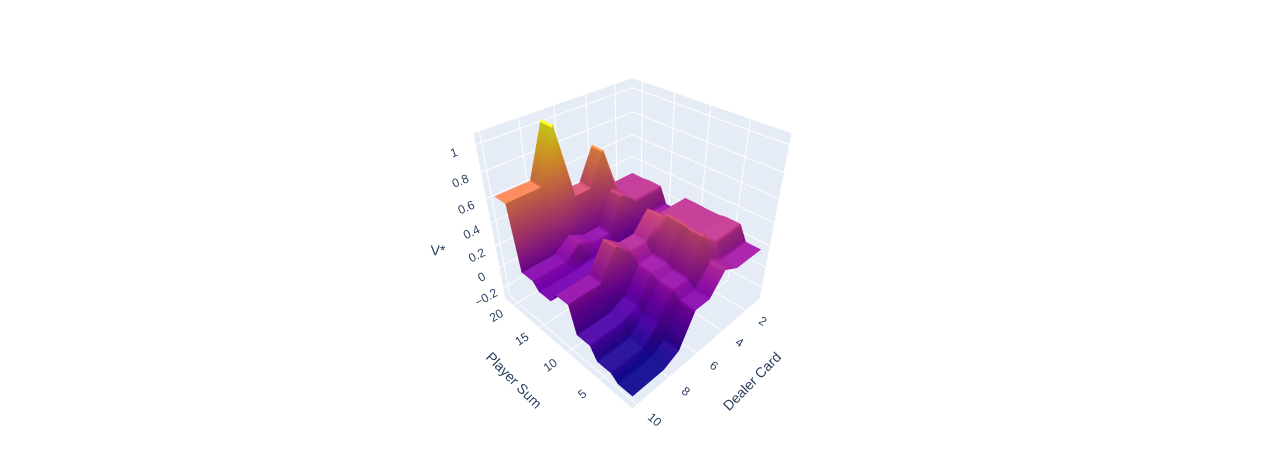

In [104]:
x, y, z = lf_agent.get_V_star()
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, showscale=False)])
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=1.5, z=1.5)
)

fig.update_layout(scene_camera=camera, 
                  scene=dict(yaxis_title='Dealer Card', xaxis_title='Player Sum', zaxis_title="V*"), 
                             margin=dict(r=20, b=10, l=10, t=10))
fig.show()

### Plotting Different $\lambda$

In [105]:
def calc_mean_error(mc_Q, sarsa_Q):
    return np.sum(np.square(mc_Q - sarsa_Q))

In [127]:
error = []
lambdas = [e * .1 for e in range(0, 11, 1)]
for _lambda in lambdas:
    lf_agent = LinearFunctionApproximation(gym=Easy21, )
    lf_agent._lambda = _lambda
    lf_agent.run(iterations=int(10000))
    error.append((_lambda, calc_mean_error(mc_agent.Q, np.swapaxes(lf_agent.Q, 0, 1))))
    print(_lambda, error[-1][-1])

0.0 29.58632969782763
0.1 25.29116445095628
0.2 28.331113566863216
0.30000000000000004 34.023385363132576
0.4 26.101176075194736
0.5 32.42500093404073
0.6000000000000001 33.812650406530935
0.7000000000000001 29.40197275925342
0.8 35.688091785968176
0.9 30.030058571031514
1.0 32.02687966594981


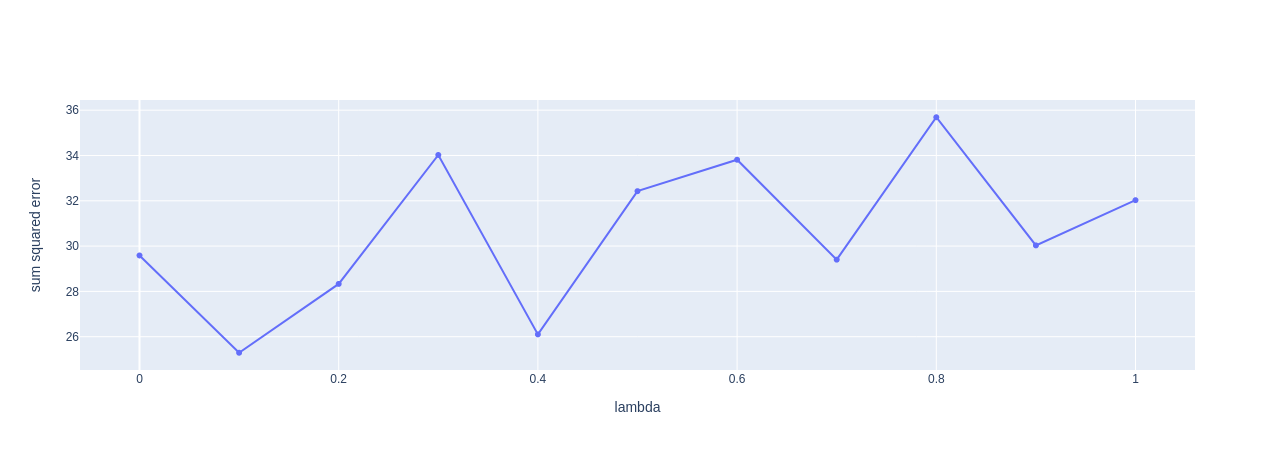

In [128]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[e[0] for e in error], y=[e[1] for e in error]))
fig.update_layout(xaxis_title='lambda', yaxis_title='sum squared error')
fig.show()

### Plotting the Learning Curve

In [133]:
error = []
lambdas = [e * .1 for e in range(0, 11, 1)]
for _lambda in lambdas:
    lf_agent = LinearFunctionApproximation(gym=Easy21, Q_star=mc_agent.Q)
    lf_agent._lambda = _lambda
    error.append((_lambda, lf_agent.run(iterations=int(1000), log_error=True)))
#     error.append((_lambda, calc_mean_error(mc_agent.Q, np.swapaxes(lf_agent.Q, 0, 1))))
    print(_lambda, error[-1][-1][-1])

0.0 (999, 34.538254635252436)
0.1 (999, 40.345285642557045)
0.2 (999, 34.82723450370783)
0.30000000000000004 (999, 33.7542768680677)
0.4 (999, 34.10657223295483)
0.5 (999, 41.40280297980871)
0.6000000000000001 (999, 35.87625453184009)
0.7000000000000001 (999, 40.065774574823635)
0.8 (999, 35.19697005793352)
0.9 (999, 35.93240972600771)
1.0 (999, 42.978300695507265)


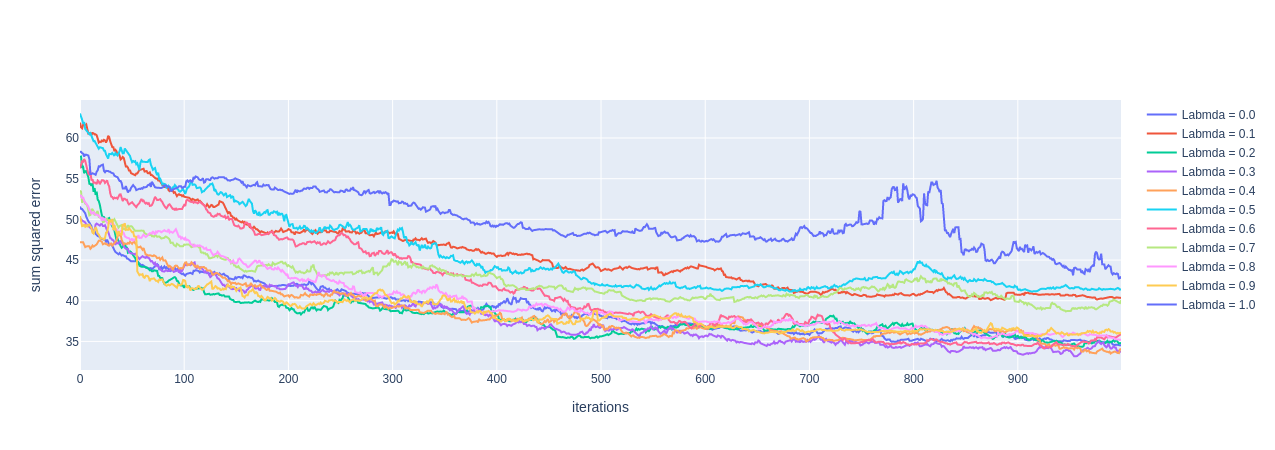

In [135]:
data = []
for _lambda, errors in error:
    data.append(go.Scatter(x=[x[0] for x in errors], y=[x[1] for x in errors], name=f"Labmda = {round(_lambda, 1)}"))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='iterations', yaxis_title='sum squared error')
fig.show()